# Basic Nighttime Lights Raster Processing


You can get these data packages via the ['sez' tag at the SDRDL Data Repository](https://data.sandiegodata.org/?s=sez)

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rowgenerators as rg
import fiona
import rasterio
import rasterio.mask
from IPython.display import display 
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from tqdm.notebook import tqdm
from requests import get  # to make GET request
import boto3
import h5py 

%matplotlib inline
sns.set_context('notebook')


In [2]:
# Open the two main data packages
sez_p = mp.open_package('http://library.metatab.org/worldbank.org-sez-1.1.1.csv')

# Displaying the package shows metadata
sez_p

# Special economic zones
`worldbank.org-sez-1.1.1` Last Update: 2021-07-12T20:47:42

_Information on special economic zones have been individually collected and researched in a study focusing on the governance of SEZ. This is just a subset (586) of the extant global SEZs, which have been estimated at 3500-4000._


## Documentation Links

* [Documentation Page](http://library.metatab.org/worldbank.org-sez-1.1.1/index.html) 
* [Dataset webpage](https://datacatalog.worldbank.org/dataset/special-economic-zones-sez) 
* [Dataset viewer web application](http://devseed.com/sez-viewer/#/BGD6) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sez](http://library.metatab.org/worldbank.org-sez-1.1.1/data/sez.csv)**. Special Economic Zones

In [3]:

# Create Dataframes
sez = sez_p.resource('sez').geoframe()

# Update the SEZ geometries to be a 20KM buffer around the point. We project to 
# EPSG:3395, World Mercator, to be able to make the buffer in meters. 
g =  sez.to_crs(3395).buffer(20_000)

sez['geo_area'] = g.area
sez['geometry'] = g.to_crs(4326)

# The operational date col is a string, so make an int year column. 
sez['year'] = pd.to_numeric(sez.operational_date, errors='coerce')

In [4]:
# Test the file upload

# Download the file
dl_fn = 'patches.h5'
with open(dl_fn, "wb") as file:
    # get request
    response = get('http://public.source.civicknowledge.com.s3.amazonaws.com/sez/sez_circ_patches.h5')
    # write to file
    file.write(response.content)
    
# Get a random selection of patches from the file
def get_hdf_keys(f):
    """Return all of the dataset keys in an HDF5 file"""
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

with h5py.File('patches.h5', 'r') as f:
    keys = get_hdf_keys(f)
    

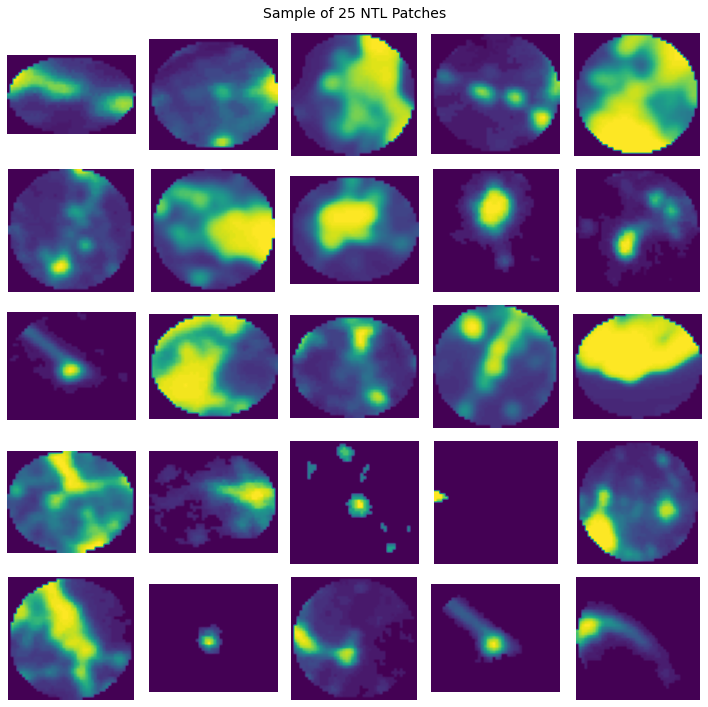

In [5]:
# Plot a random sample
from random import shuffle
shuffle(keys)

fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = np.ravel(axes)

with h5py.File('patches.h5', 'r') as f:
    for k, a in zip(keys[:len(axes)], axes):
        r = f[k][:]
        a.set_axis_off()
        show(r, ax=a)

fig.suptitle('Sample of 25 NTL Patches', fontsize=14)
plt.tight_layout()

In [15]:
with h5py.File('patches.h5', 'r') as f:
    
    keys = get_hdf_keys(f)
    rasters = []
    for k in keys:
        _, sez_id, year = k.split('/')
        rasters.append( (int(year), sez_id, np.nansum(f[k][:])))
        
t = pd.DataFrame(rasters, columns=['year', 'unique_id', 'pixel_sum'])   
t.head()

,year,unique_id,pixel_sum
0,1992,AGO1,8198
1,1993,AGO1,9590
2,1994,AGO1,9593
3,1995,AGO1,11546
4,1996,AGO1,12289


In [16]:
sez[['unique_id', 'geo_area', 'year']]

,unique_id,geo_area,year
0,URY12,1.254619e+09,1923.0
1,URY2,1.254619e+09,1923.0
2,COL2,1.254619e+09,1958.0
3,GUY3,1.254619e+09,1960.0
4,IND186,1.254619e+09,1965.0
...,...,...,...
579,IDN14,1.254619e+09,NaN
580,JAM3,1.254619e+09,NaN
581,IDN33,1.254619e+09,NaN
582,CMR4,1.254619e+09,NaN


In [17]:
len(t)

15768

In [18]:

t = t.merge(sez[['unique_id', 'geo_area', 'year']].rename(columns={'year':'op_year'}), on='unique_id')
t['mean_light'] = t.pixel_sum / t.geo_area

# Unit Norm
t_ = t.mean_light-t.mean_light.min()
t['mean_light_un'] = (t_/t_.max())

t = t[t.op_year > 1996] # so we are certain to have a few years of light data before
g = t.groupby('unique_id')

/Users/eric/opt/anaconda3/envs/sez/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eric/opt/anaconda3/envs/sez/lib/python3.7/site-packages/numpy/lib/polynomial.py:659: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


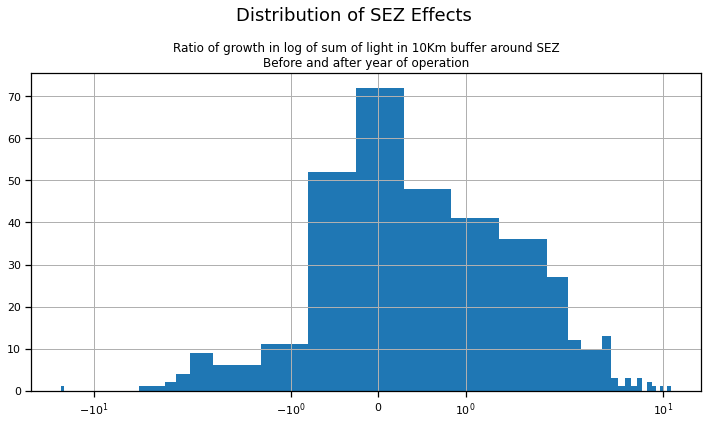

In [19]:
def slope_(df):
    from numpy.linalg import LinAlgError
    

    try:
        x = np.log(df['mean_light'])
        y = df['year'] - min(df['year'])
        
        fit = np.polyfit(x,y,1)
    except LinAlgError:
        # Didn't converge
        return np.nan
    except ValueError:
        # Something Else
        return np.nan
   
    return fit[0]

def slope(df):
    bf = df[df.year<df.op_year].sort_values('year').reset_index(drop=True)
    af = df[df.year>df.op_year].sort_values('year').reset_index(drop=True)

    
    return pd.Series([slope_(bf), slope_(af)])

slopes = g.apply(slope).rename(columns={0:'pre_slope',1:'post_slope'}).reset_index()
slopes['slope_diff'] = (slopes.post_slope - slopes.pre_slope)/slopes.pre_slope
plt.xscale('symlog')
slopes.slope_diff.hist(bins = 50, figsize=(10, 6))
plt.suptitle('Distribution of SEZ Effects', fontsize=18)
plt.title('Ratio of growth in log of sum of light in 10Km buffer around SEZ\nBefore and after year of operation')
plt.tight_layout()

In [20]:
t

,year,unique_id,pixel_sum,geo_area,op_year,mean_light,mean_light_un
0,1992,AGO1,8198,1.254619e+09,2011.0,0.000007,0.098361
1,1993,AGO1,9590,1.254619e+09,2011.0,0.000008,0.115063
2,1994,AGO1,9593,1.254619e+09,2011.0,0.000008,0.115099
3,1995,AGO1,11546,1.254619e+09,2011.0,0.000009,0.138531
4,1996,AGO1,12289,1.254619e+09,2011.0,0.000010,0.147446
...,...,...,...,...,...,...,...
15763,2014,ZWE1,26290,1.254619e+09,2015.0,0.000021,0.315432
15764,2015,ZWE1,25208,1.254619e+09,2015.0,0.000020,0.302450
15765,2016,ZWE1,26079,1.254619e+09,2015.0,0.000021,0.312900
15766,2017,ZWE1,27026,1.254619e+09,2015.0,0.000022,0.324263
